# MASTER - Notebook 3
### Matteo Grazioso 884055

In [7]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from datetime import datetime
import re
import folium
from folium.plugins import MarkerCluster
from geopy.geocoders import Nominatim
from pandas import Timestamp
import json
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
# import hdbscan
from sklearn.cluster import OPTICS
import socket


 

import myfunctions as mf # Custom functions

In [8]:
# Disply all columns and all rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [9]:
# Given a file send and emailwith the text of the file
import smtplib
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart
from email.mime.base import MIMEBase
from email import encoders

def send_email(sender_email='', sender_password='', receiver_email='', subject='MASTER', file_att:list=[], file_text:str=''):
    if not sender_email:
        sender_email = 'matteo.grazioso.scuola@outlook.it'
    if not sender_password:
        sender_password = 'Fllottisb%19690321'
    if not receiver_email:
        receiver_email = '884055@stud.unive.it'
    # Outlook SMTP server and port
    smtp_server = 'smtp-mail.outlook.com'
    smtp_port = 587

    # Create a multipart message and set headers
    email_message = MIMEMultipart()
    email_message['From'] = sender_email
    email_message['To'] = receiver_email
    email_message['Subject'] = subject

    # The message is the text of the file 
    with open(file_text, 'r') as f:
        message = f.read()

    # Concatenate to the message my signature
    message += '\n\n\n\nGrazioso Matteo \nStudente del Corso di Laurea in Informatica – Data Science'

    # Add message body
    email_message.attach(MIMEText(message, 'plain'))

    if file_att:
        for file_path in file_att:
            # Open the file in bynary
            with open(file_path, 'rb') as attachment:
                # Add file as application/octet-stream
                # Email client can usually download this automatically as attachment
                part = MIMEBase('application', 'octet-stream')
                part.set_payload(attachment.read())

            # Encode file in ASCII characters to send by email    
            encoders.encode_base64(part)

            # Add header as key/value pair to attachment part
            part.add_header('Content-Disposition', 'attachment', filename=file_path)

            # Add attachment to message and convert message to string
            email_message.attach(part)

    # Create SMTP session and login
    with smtplib.SMTP(smtp_server, smtp_port) as server:
        server.starttls()
        server.login(sender_email, sender_password)

        # Send email
        server.send_message(email_message)



In [10]:
# send_email(subject='Completion of Algorithm Execution', file_text='email.txt', file_att=['data/plots/esportazioneCompleta/plot_esportazioneCompleta_clusters.png'])

In [14]:
def cluster_algorithms (dataset_path: str):
   # Each dataset already contains the columns that are needed for the analysis in particular geographical coordinates

    # For each dataset, execute the following steps:
    # 1. Read the dataset
    # 2. Drop the columns that are not needed
    # 3. Normalize the data
    # 4. Clustering of the data with K-Means algorithm: use silhouette score to find the optimal number of clusters
    # 5. Plot the clusters on a map with Folium library and save the map as html file
    # 6. Export the map as png file
    # 7. Represet the clusters with a plot and save the plot as png file
    # 8. Clustering with DBSCAN algorithm: use silhouette score to find the optimal number of clusters
    # 9. Plot the clusters on a map with Folium library and save the map as html file
    # 10. Export the map as png file
    # 11. Represet the clusters with a plot and save the plot as png file
    # 12. Clustering with HDBSCAN algorithm: use silhouette score to find the optimal number of clusters
    # 13. Plot the clusters on a map with Folium library and save the map as html file
    # 14. Export the map as png file
    # 15. Represet the clusters with a plot and save the plot as png file
    # 16. Clustering with OPTICS algorithm: use silhouette score to find the optimal number of clusters
    # 17. Plot the clusters on a map with Folium library and save the map as html file
    # 18. Export the map as png file
    # 19. Represet the clusters with a plot and save the plot as png file

    # Repeat the same steps for each dataset
    # All the information must be save in a txt file; when each dataset is processed, send the txt file as email attachment

    # Create a txt file to save the information
    file = open('data/processed/summary.txt', 'w')
    file.write('Summary of the clustering analysis\n\n')
    file.write('Executed in ' + socket.gethostname() + '\n\n')
    print('Executed in ' + socket.gethostname() + '\n\n')

    # # Dataset 1: esportazioneCompleta.csv
    #
    # # 1. Read the dataset (dataset_path)
    df = pd.read_csv(dataset_path, sep=',')
    # selected_dataset = data/processed/esportazioneCompleta/df_esportazioneCompleta_GEO.csv -> esportazioneCompleta
    # data/processed/esportazionePasqua23/df_divided_part1_GEO.csv -> esportazionePasqua23_part1
    selected_dataset = dataset_path.split('/')[2].split('.')[0]
    # If the dataset has part1 or part2 in the name, mantain it
    if 'part' in dataset_path:
        selected_dataset = selected_dataset + '_' + dataset_path.split('/')[3].split('_')[2]

    print(selected_dataset)
    print(len(df))
    df.head()
    # take only a part of the dataset
    percentage = 0.1
    df = df[:int(len(df) * percentage)]
    file.write('Dataset: ' + selected_dataset + '\n')
    print('Dataset: ' + selected_dataset + '\n')
    file.write('Considered percentage of the dataset: ' + str(percentage * 100) + '%\n')
    print('Considered percentage of the dataset: ' + str(percentage * 100) + '%\n')
    print('Lenght of the dataset: ' + str(len(df)) + '\n')
    file.write('Lenght of the dataset: ' + str(len(df)) + '\n\n')
    print(df.head())
    file.write(df.head().to_string() + '\n\n')
    # # 2. Drop the columns that are not needed
    # Mantain only the columns that are needed for the analysis: DATA ORA, SERIALE, LATITUDINE, LONGITUDINE
    df = df[['DATA', 'ORA', 'SERIALE', 'LATITUDE', 'LONGITUDE']]
    df.head()
    # # 3. Normalize the data
    # Normalize the data: convert the column DATA ORA in datetime format
    # If ORA contains also the date, remove the date
    df['DATA'] = pd.to_datetime(df['DATA'], format='%Y-%m-%d')
    if len(df['ORA'][0]) > 8:
        df['ORA'] = df['ORA'].apply(lambda x: x.split(' ')[1])
    df['ORA'] = pd.to_datetime(df['ORA'], format='%H:%M:%S')
    df.head()

    # # 4. Clustering of the data with K-Means algorithm: use silhouette score to find the optimal number of clusters
    file.write('K-Means clustering\n\tStart time: ' + str(datetime.now().strftime("%d/%m/%Y %H:%M:%S")) + '\n')
    print('K-Means clustering\n\tStart time: ' + str(datetime.now().strftime("%d/%m/%Y %H:%M:%S")) + '\n')
    X = df[['LATITUDE', 'LONGITUDE']]
    # Standardize the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    # Find the optimal number of clusters
    sil = []
    kmax = 10
    from sklearn.cluster import KMeans
    # X_scaled_sil is the first 10% of the dataset
    X_scaled_sil = X_scaled[:int(len(X_scaled) * 0.1)] 
    for k in range(2, kmax+1):
        kmeans = KMeans(n_clusters = k).fit(X_scaled_sil)
        labels = kmeans.labels_
        sil_new = silhouette_score(X_scaled_sil, labels, metric = 'euclidean')
        sil.append(sil_new)
        print('Silhouette score for ' + str(k) + ' clusters: ' + str(sil_new))
    # Plot the silhouette score
    plt.plot(sil)
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette score')
    plt.title('Silhouette score for K-Means clustering')
    plt.savefig('data/processed/' + selected_dataset + '/silhouette_score_KMeans.png')
    plt.show()
    # Apply K-Means clustering with the optimal number of clusters
    optimal_number_of_clusters = np.argmax(sil)
    file.write('Optimal number of clusters: ' + str(optimal_number_of_clusters) + '\n')
    print('Optimal number of clusters: ' + str(optimal_number_of_clusters) + '\n')
    kmeans = KMeans(n_clusters = optimal_number_of_clusters).fit(X_scaled)
    labels = kmeans.labels_
    # Add the column CLUSTER to the dataset
    df['CLUSTER'] = labels
    df.head()
    # Evaluate the clustering performance using silhouette score
    silhouette_score(X_scaled, labels, metric = 'euclidean')
    # Save the information about the clusters in the txt file
    file.write('Number of clusters: ' + str(len(df['CLUSTER'].unique())) + '\n')
    print('Number of clusters: ' + str(len(df['CLUSTER'].unique())) + '\n')
    file.write('Silhouette score: ' + str(silhouette_score(X_scaled, labels, metric = 'euclidean')) + '\n\n')
    print('Silhouette score: ' + str(silhouette_score(X_scaled, labels, metric = 'euclidean')) + '\n\n')
    for cluster in np.unique(labels):  
        file.write("Cluster: " + str(cluster) + '\n')
        print("Cluster: " + str(cluster))
        file.write("Number of Users: " + str(len(df[df['CLUSTER'] == cluster])) + '\n\n')
        print("Number of Users: " + str(len(df[df['CLUSTER'] == cluster])) + '\n\n')

    # # 5. Plot the clusters on a map with Folium library and save the map as html file
    # Create a map with Folium library
    map = folium.Map(location=[df['LATITUDE'].mean(), df['LONGITUDE'].mean()], zoom_start=5)
    # Add the clusters to the map
    marker_cluster = MarkerCluster().add_to(map)

    visited_stops = []

    for i in range(len(df)):
        # Only if the coordinates are not already in the map
        if [df.iloc[i]['LATITUDE'], df.iloc[i]['LONGITUDE']] not in visited_stops:
            folium.Marker([df.iloc[i]['LATITUDE'], df.iloc[i]['LONGITUDE']], popup=df.iloc[i]['CLUSTER']).add_to(marker_cluster)
            visited_stops.append([df.iloc[i]['LATITUDE'], df.iloc[i]['LONGITUDE']])
    # Save the map as html file
    map.save('data/processed/' + selected_dataset + '/map_KMeans.html')

    # # 7. Represet the clusters with a plot and save the plot as png file
    # Plot the clusters
    plt.figure(figsize=(10, 10))
    sns.scatterplot(x='LATITUDE', y='LONGITUDE', hue='CLUSTER', data=df, palette='Set1')
    plt.title('Clusters for K-Means clustering')
    plt.savefig('data/processed/' + selected_dataset + '/clusters_KMeans.png')
    plt.show()
    file.write('Finished K-Means clustering\n\tTime: ' + str(datetime.now().strftime("%H:%M:%S")) + '\n\n')
    file.close()
    # Send also html file as email attachment
    send_email(subject = selected_dataset + ' (' + str(percentage * 100) + '%' + ') ' + 'K-Means clustering completed',
               file_text='data/processed/summary.txt', 
               file_att=['data/processed/' + selected_dataset + '/silhouette_score_KMeans.png', 
                         'data/processed/' + selected_dataset + '/map_KMeans.html', 
                         'data/processed/' + selected_dataset + '/clusters_KMeans.png'])

    # Empty the txt file
    file = open('data/processed/summary.txt', 'w')
    # Remove the column CLUSTER
    df = df.drop(columns=['CLUSTER'])

    # # 8. Clustering with DBSCAN algorithm: use silhouette score to find the optimal number of clusters
    file = open('data/processed/summary.txt', 'a')
    file.write('Summary of the clustering analysis\n\n')
    file.write('Executed in ' + socket.gethostname() + '\n\n')
    print('Executed in ' + socket.gethostname() + '\n\n')
    file.write('Dataset: ' + selected_dataset + '\n')
    print('Dataset: ' + selected_dataset + '\n')
    file.write('Considered percentage of the dataset: ' + str(percentage * 100) + '%\n')
    print('Considered percentage of the dataset: ' + str(percentage * 100) + '%\n')
    print('Lenght of the dataset: ' + str(len(df)) + '\n')
    file.write('Lenght of the dataset: ' + str(len(df)) + '\n\n')
    print(df.head())
    file.write(df.head().to_string() + '\n\n')

    print('DBSCAN clustering\n\tStart time: ' + str(datetime.now().strftime("%d/%m/%Y %H:%M:%S")) + '\n')
    file.write('Dataset: ' + selected_dataset + '\n')
    print('Dataset: ' + selected_dataset + '\n')
    file.write('DBSCAN clustering\n\tStart time: ' + str(datetime.now().strftime("%d/%m/%Y %H:%M:%S")) + '\n')
    print('DBSCAN clustering\n\tStart time: ' + str(datetime.now().strftime("%d/%m/%Y %H:%M:%S")) + '\n')
    X = df[['LATITUDE', 'LONGITUDE']]
    # Standardize the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    # Find the optimal number of clusters
    sil = []
    eps = np.arange(0.1, 1.0, 0.1)
    for e in eps:
        dbscan = DBSCAN(eps=e, min_samples=5).fit(X_scaled)
        labels = dbscan.labels_
        sil_new = silhouette_score(X_scaled, labels, metric = 'euclidean')
        sil.append(sil_new)
        print('Silhouette score for ' + str(e) + ' epsilon: ' + str(sil_new))
    # Plot the silhouette score
    plt.plot(sil)
    plt.xlabel('Epsilon')
    plt.ylabel('Silhouette score')
    plt.title('Silhouette score for DBSCAN clustering')
    plt.savefig('data/processed/' + selected_dataset + '/silhouette_score_DBSCAN.png')
    plt.show()
    # Apply DBSCAN clustering with the optimal number of clusters
    optimal_number_of_clusters = float(eps[np.argmax(sil)])
    file.write('Optimal number of clusters: ' + str(optimal_number_of_clusters) + '\n')
    print('Optimal number of clusters: ' + str(optimal_number_of_clusters) + '\n')
    dbscan = DBSCAN(eps=optimal_number_of_clusters, min_samples=5).fit(X_scaled)

    labels = dbscan.labels_
    # Add the column CLUSTER to the dataset
    df['CLUSTER'] = labels
    df.head()
    # Evaluate the clustering performance using silhouette score
    silhouette_score(X_scaled, labels, metric = 'euclidean')
    # Save the information about the clusters in the txt file
    file.write('Number of clusters: ' + str(len(df['CLUSTER'].unique())) + '\n')
    print('Number of clusters: ' + str(len(df['CLUSTER'].unique())) + '\n')
    file.write('Silhouette score: ' + str(silhouette_score(X_scaled, labels, metric = 'euclidean')) + '\n\n')
    print('Silhouette score: ' + str(silhouette_score(X_scaled, labels, metric = 'euclidean')) + '\n\n')
    for cluster in np.unique(labels):
        file.write("Cluster: " + str(cluster) + '\n')
        print("Cluster: " + str(cluster))
        file.write("Number of Users: " + str(len(df[df['CLUSTER'] == cluster])) + '\n\n')
        print("Number of Users: " + str(len(df[df['CLUSTER'] == cluster])) + '\n\n')

    # # 9. Plot the clusters on a map with Folium library and save the map as html file
    # Create a map with Folium library
    map = folium.Map(location=[df['LATITUDE'].mean(), df['LONGITUDE'].mean()], zoom_start=5)
    # Add the clusters to the map
    marker_cluster = MarkerCluster().add_to(map)

    visited_stops = []

    for i in range(len(df)):
        # Only if the coordinates are not already in the map
        if [df.iloc[i]['LATITUDE'], df.iloc[i]['LONGITUDE']] not in visited_stops:
            folium.Marker([df.iloc[i]['LATITUDE'], df.iloc[i]['LONGITUDE']], popup=df.iloc[i]['CLUSTER']).add_to(marker_cluster)
            visited_stops.append([df.iloc[i]['LATITUDE'], df.iloc[i]['LONGITUDE']])
    # Save the map as html file
    map.save('data/processed/' + selected_dataset + '/map_DBSCAN.html')

    for cluster in np.unique(labels):
        file.write("Cluster: " + str(cluster) + '\n')
        print("Cluster: " + str(cluster))
        file.write("Number of Users: " + str(len(df[df['CLUSTER'] == cluster])) + '\n\n')
        print("Number of Users: " + str(len(df[df['CLUSTER'] == cluster])) + '\n\n')

    # # 11. Represet the clusters with a plot and save the plot as png file
    # Plot the clusters
    plt.figure(figsize=(10, 10))
    sns.scatterplot(x='LATITUDE', y='LONGITUDE', hue='CLUSTER', data=df, palette='Set1')
    plt.title('Clusters for DBSCAN clustering')
    plt.savefig('data/processed/' + selected_dataset + '/clusters_DBSCAN.png')
    plt.show()
    file.write('Finished DBSCAN clustering\n\tTime: ' + str(datetime.now().strftime("%H:%M:%S")) + '\n\n')
    file.close()
    # Send also html file as email attachment
    send_email(subject= selected_dataset + ' (' + str(percentage * 100) + '%' + ') ' + 'DBSCAN clustering completed',
               file_text='data/processed/summary.txt', 
               file_att=['data/processed/' + selected_dataset + '/silhouette_score_DBSCAN.png', 
                         'data/processed/' + selected_dataset + '/map_DBSCAN.html', 
                         'data/processed/' + selected_dataset + '/clusters_DBSCAN.png'])

    # Empty the txt file
    file = open('data/processed/summary.txt', 'w')
    # Remove the column CLUSTER
    df = df.drop(columns=['CLUSTER'])

    # # # 12. Clustering with HDBSCAN algorithm: use silhouette score to find the optimal number of clusters
    # file = open('data/processed/summary.txt', 'a')
    # file.write('Summary of the clustering analysis\n\n')
    # file.write('Dataset: ' + selected_dataset + '\n')
    # file.write('HDBSCAN clustering\n\tStart time: ' + str(datetime.now().strftime("%H:%M:%S")) + '\n')
    # X = df[['LATITUDE', 'LONGITUDE']]
    # # Standardize the data
    # scaler = StandardScaler()
    # X_scaled = scaler.fit_transform(X)
    # # Find the optimal number of clusters
    # sil = []
    # min_cluster_size = np.arange(2, 10, 1)
    # for m in min_cluster_size:
    #     h = hdbscan.HDBSCAN(min_cluster_size=m).fit(X_scaled)
    #     labels = h.labels_
    #     sil.append(silhouette_score(X_scaled, labels, metric = 'euclidean'))
    # # Plot the silhouette score
    # plt.plot(sil)
    # plt.xlabel('Min cluster size')
    # plt.ylabel('Silhouette score')
    # plt.title('Silhouette score for HDBSCAN clustering')
    # plt.savefig('data/processed/' + selected_dataset + '/silhouette_score_HDBSCAN.png')
    # plt.show()
    # # Apply HDBSCAN clustering with the optimal number of clusters
    # optimal_number_of_clusters = int(min_cluster_size[np.argmax(sil)])
    # file.write('Optimal number of clusters: ' + str(optimal_number_of_clusters) + '\n')
    # h = hdbscan.HDBSCAN(min_cluster_size=optimal_number_of_clusters).fit(X_scaled)
    # labels = h.labels_
    # # Add the column CLUSTER to the dataset
    # df['CLUSTER'] = labels
    # df.head()
    # # Evaluate the clustering performance using silhouette score
    # silhouette_score(X_scaled, labels, metric = 'euclidean')
    # # Save the information about the clusters in the txt file
    # file.write('Number of clusters: ' + str(len(df['CLUSTER'].unique())) + '\n')
    # file.write('Silhouette score: ' + str(silhouette_score(X_scaled, labels, metric = 'euclidean')) + '\n\n')
    # for cluster in np.unique(labels):
    #     file.write("Cluster: " + str(cluster) + '\n')
    #     file.write("Number of Users: " + str(len(df[df['CLUSTER'] == cluster])) + '\n\n')

    # # # 13. Plot the clusters on a map with Folium library and save the map as html file
    # # Create a map with Folium library
    # map = folium.Map(location=[df['LATITUDE'].mean(), df['LONGITUDE'].mean()], zoom_start=5)
    # # Add the clusters to the map
    # marker_cluster = MarkerCluster().add_to(map)

    # visited_stops = []

    # for i in range(len(df)):
    #     # Only if the coordinates are not already in the map
    #     if [df.iloc[i]['LATITUDE'], df.iloc[i]['LONGITUDE']] not in visited_stops:
    #         folium.Marker([df.iloc[i]['LATITUDE'], df.iloc[i]['LONGITUDE']], popup=df.iloc[i]['CLUSTER']).add_to(marker_cluster)
    #         visited_stops.append([df.iloc[i]['LATITUDE'], df.iloc[i]['LONGITUDE']])
    # # Save the map as html file
    # map.save('data/processed/' + selected_dataset + '/map_HDBSCAN.html')

    # for cluster in np.unique(labels):
    #     file.write("Cluster: " + str(cluster) + '\n')
    #     file.write("Number of Users: " + str(len(df[df['CLUSTER'] == cluster])) + '\n\n')

    # # # 15. Represet the clusters with a plot and save the plot as png file
    # # Plot the clusters
    # plt.figure(figsize=(10, 10))
    # sns.scatterplot(x='LATITUDE', y='LONGITUDE', hue='CLUSTER', data=df, palette='Set1')
    # plt.title('Clusters for HDBSCAN clustering')
    # plt.savefig('data/processed/' + selected_dataset + '/clusters_HDBSCAN.png')
    # plt.show()
    # file.write('Finished HDBSCAN clustering\n\tTime: ' + str(datetime.now().strftime("%H:%M:%S")) + '\n\n')
    # file.close()
    # # Send also html file as email attachment
    # send_email(subject='HDBSCAN clustering completed', file_text='data/processed/summary.txt', file_att=['data/processed/' + selected_dataset + '/silhouette_score_HDBSCAN.png', 'data/processed/' + selected_dataset + '/map_HDBSCAN.html', 'data/processed/' + selected_dataset + '/clusters_HDBSCAN.png'])

    # # Empty the txt file
    # file = open('data/processed/summary.txt', 'w')
    # # Remove the column CLUSTER
    # df = df.drop(columns=['CLUSTER'])

    # # 16. Clustering with OPTICS algorithm: use silhouette score to find the optimal number of clusters
    file = open('data/processed/summary.txt', 'a')
    file.write('Summary of the clustering analysis\n\n')
    print('Summary of the clustering analysis\n\n')
    file.write('Executed in ' + socket.gethostname() + '\n\n')
    print('Executed in ' + socket.gethostname() + '\n\n')
    file.write('Dataset: ' + selected_dataset + '\n')
    print('Dataset: ' + selected_dataset + '\n')
    file.write('Considered percentage of the dataset: ' + str(percentage * 100) + '%\n')
    print('Considered percentage of the dataset: ' + str(percentage * 100) + '%\n')
    print('Lenght of the dataset: ' + str(len(df)) + '\n')
    file.write('Lenght of the dataset: ' + str(len(df)) + '\n\n')
    print(df.head())
    file.write(df.head().to_string() + '\n\n')

    file.write('OPTICS clustering\n\tStart time: ' + str(datetime.now().strftime("%d/%m/%Y %H:%M:%S")) + '\n')
    print('OPTICS clustering\n\tStart time: ' + str(datetime.now().strftime("%d/%m/%Y %H:%M:%S")) + '\n')
    X = df[['LATITUDE', 'LONGITUDE']]
    # Standardize the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    # Find the optimal number of clusters
    sil = []
    min_samples = np.arange(2, 10, 1)
    for m in min_samples:
        optics = OPTICS(min_samples=m).fit(X_scaled)
        labels = optics.labels_
        sil_new = silhouette_score(X_scaled, labels, metric = 'euclidean')
        sil.append(sil_new)
        print('Silhouette score for ' + str(m) + ' min samples: ' + str(sil_new))
    # Plot the silhouette score
    plt.plot(sil)
    plt.xlabel('Min samples')
    plt.ylabel('Silhouette score')
    plt.title('Silhouette score for OPTICS clustering')
    plt.savefig('data/processed/' + selected_dataset + '/silhouette_score_OPTICS.png')
    plt.show()
    # Apply OPTICS clustering with the optimal number of clusters
    optimal_number_of_clusters = int(min_samples[np.argmax(sil)])
    file.write('Optimal number of clusters: ' + str(optimal_number_of_clusters) + '\n')
    print('Optimal number of clusters: ' + str(optimal_number_of_clusters) + '\n')
    optics = OPTICS(min_samples=optimal_number_of_clusters).fit(X_scaled)
    labels = optics.labels_
    # Add the column CLUSTER to the dataset
    df['CLUSTER'] = labels
    df.head()
    # Evaluate the clustering performance using silhouette score
    silhouette_score(X_scaled, labels, metric = 'euclidean')
    # Save the information about the clusters in the txt file
    file.write('Number of clusters: ' + str(len(df['CLUSTER'].unique())) + '\n')
    print('Number of clusters: ' + str(len(df['CLUSTER'].unique())) + '\n')
    file.write('Silhouette score: ' + str(silhouette_score(X_scaled, labels, metric = 'euclidean')) + '\n\n')
    print('Silhouette score: ' + str(silhouette_score(X_scaled, labels, metric = 'euclidean')) + '\n\n')
    for cluster in np.unique(labels):
        file.write("Cluster: " + str(cluster) + '\n')
        print("Cluster: " + str(cluster))
        file.write("Number of Users: " + str(len(df[df['CLUSTER'] == cluster])) + '\n\n')
        print("Number of Users: " + str(len(df[df['CLUSTER'] == cluster])) + '\n\n')

    # # 17. Plot the clusters on a map with Folium library and save the map as html file
    # Create a map with Folium library
    map = folium.Map(location=[df['LATITUDE'].mean(), df['LONGITUDE'].mean()], zoom_start=5)
    # Add the clusters to the map
    marker_cluster = MarkerCluster().add_to(map)

    visited_stops = []

    for i in range(len(df)):
        # Only if the coordinates are not already in the map
        if [df.iloc[i]['LATITUDE'], df.iloc[i]['LONGITUDE']] not in visited_stops:
            folium.Marker([df.iloc[i]['LATITUDE'], df.iloc[i]['LONGITUDE']], popup=df.iloc[i]['CLUSTER']).add_to(marker_cluster)
            visited_stops.append([df.iloc[i]['LATITUDE'], df.iloc[i]['LONGITUDE']])
    # Save the map as html file
    map.save('data/processed/' + selected_dataset + '/map_OPTICS.html')

    for cluster in np.unique(labels):
        file.write("Cluster: " + str(cluster) + '\n')
        print("Cluster: " + str(cluster))
        file.write("Number of Users: " + str(len(df[df['CLUSTER'] == cluster])) + '\n\n')
        print("Number of Users: " + str(len(df[df['CLUSTER'] == cluster])) + '\n\n')

    # # 19. Represet the clusters with a plot and save the plot as png file
    # Plot the clusters
    plt.figure(figsize=(10, 10))
    sns.scatterplot(x='LATITUDE', y='LONGITUDE', hue='CLUSTER', data=df, palette='Set1')
    plt.title('Clusters for OPTICS clustering')

    plt.savefig('data/processed/' + selected_dataset + '/clusters_OPTICS.png')
    plt.show()
    file.write('Finished OPTICS clustering\n\tTime: ' + str(datetime.now().strftime("%H:%M:%S")) + '\n\n')
    file.close()
    # Send also html file as email attachment
    send_email(subject=selected_dataset + ' (' + str(percentage * 100) + '%' + ') ' + 'OPTICS clustering completed',
               file_text='data/processed/summary.txt', 
               file_att=['data/processed/' + selected_dataset + '/silhouette_score_OPTICS.png', 
                         'data/processed/' + selected_dataset + '/map_OPTICS.html', 
                         'data/processed/' + selected_dataset + '/clusters_OPTICS.png'])



    

In [ ]:
cluster_algorithms('data/processed/esportazioneCompleta/df_esportazioneCompleta_GEO.csv')
cluster_algorithms('data/processed/esportazionePasqua23/df_esportazionePasqua23_part1_GEO.csv')
cluster_algorithms('data/processed/esportazionePasqua23/df_esportazionePasqua23_part2_GEO.csv')

Executed in MacBook-Air-di-Matteo-3.local


validazioni
4427561
Dataset: validazioni

Considered percentage of the dataset: 10.0%

Lenght of the dataset: 442756

         DATA       ORA     DATA_VALIDAZIONE            SERIALE  FERMATA  \
0  2022-05-13  00:00:00  2022-05-13 00:00:00  65676291870913797     5089   
1  2022-05-13  00:00:00  2022-05-13 00:00:00  36141384536591364     5032   
2  2022-05-13  00:00:00  2022-05-13 00:00:00  36144856606063108     5031   
3  2022-05-13  00:00:00  2022-05-13 00:00:00  36144856474364932      506   
4  2022-05-13  00:00:00  2022-05-13 00:00:00  36144856606062852     5031   

  DESCRIZIONE  TITOLO  TICKET_CODE        DESCRIZIONE_TITOLO   LATITUDE  \
0    FERROVIA   11149            4  7GG-TPL 43,60-COMVE16,40  45.440937   
1    FERROVIA   11107            2   48H-TPL 24,90-COMVE5,10  45.440937   
2   P.LE ROMA   11108            3   72H-TPL 33,40-COMVE6,60  45.438667   
3     VENEZIA   11261            1  DAILY PASS VENEZIA - AVM  45.491853   
4   P.

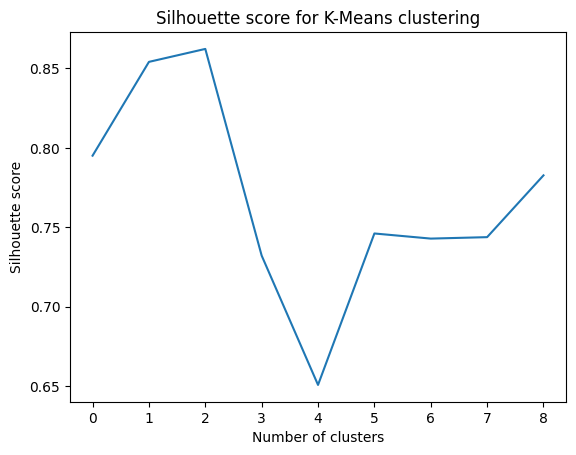

Optimal number of clusters: 2

Number of clusters: 2

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/matteograzioso/Library/Python/3.11/lib/python/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/d8/fzh8cxg9093fp0_k92hwz6yr0000gn/T/ipykernel_1674/2396451906.py", line 1, in <module>
    cluster_algorithms('data/processed/validazioni/df_validazioni_GEO.csv')
  File "/var/folders/d8/fzh8cxg9093fp0_k92hwz6yr0000gn/T/ipykernel_1674/1022789394.py", line 113, in cluster_algorithms
    print('Silhouette score: ' + str(silhouette_score(X_scaled, labels, metric = 'euclidean')) + '\n\n')
                                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 211, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/

In [15]:
cluster_algorithms('data/processed/validazioni/df_validazioni_GEO.csv')